<a href="https://colab.research.google.com/github/Tahahaha7/Quantitative_Trading/blob/main/%5BIL181%5D_ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install pmdarima

In [57]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pmdarima.arima import auto_arima

In [84]:
data = pdr.get_data_yahoo('AAL','2015-03-02','2020-03-02')['Adj Close']
data

Date
2015-03-02    45.866631
2015-03-03    46.303371
2015-03-04    46.474262
2015-03-05    45.952080
2015-03-06    45.572308
                ...    
2020-02-25    23.120001
2020-02-26    22.309999
2020-02-27    20.600000
2020-02-28    19.049999
2020-03-02    18.860001
Name: Adj Close, Length: 1260, dtype: float64

In [85]:
return_data = data/data.shift(1)
return_data = return_data.dropna()

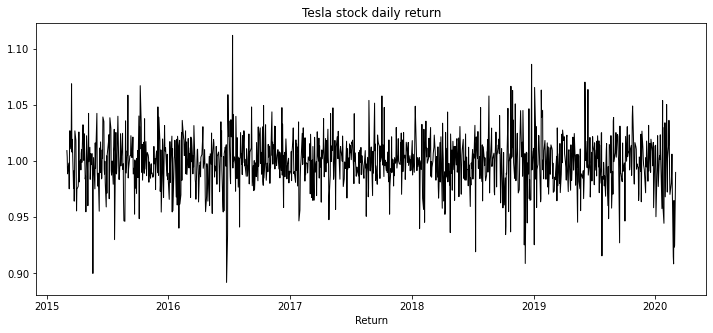

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(return_data.index, return_data, 'k', lw=1);
plt.title('Tesla stock daily return'); plt.xlabel('Return');

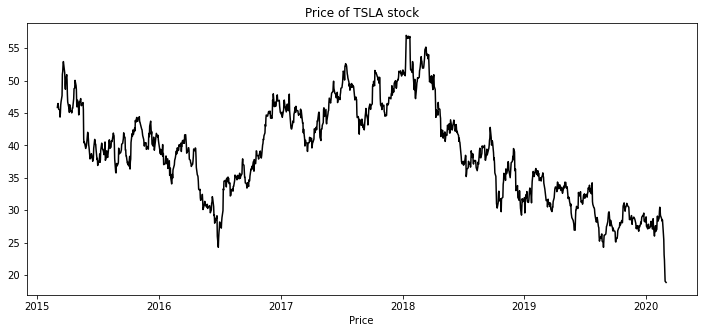

In [87]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data, 'k');
plt.title('Price of TSLA stock'); plt.xlabel('Price');

In [88]:
# Splitting the data into train and test (409/97)

train_return_data = return_data[:'2019-03-01']
test_return_data = return_data['2019-03-01':]

## $\text{Exploratory Data Analysis}$

<Figure size 432x288 with 0 Axes>

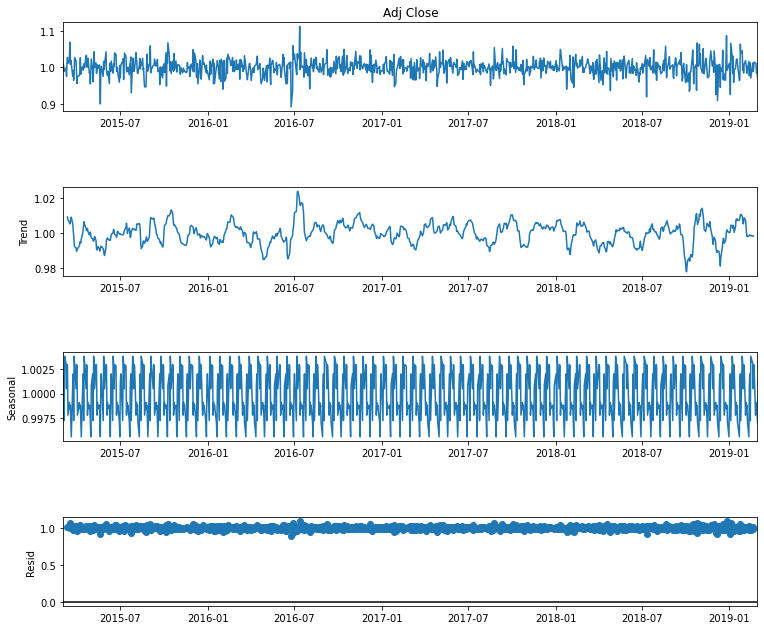

In [108]:
decompose = seasonal_decompose(train_return_data, model='multiplicative', freq = 14)
fig = plt.figure();
fig = decompose.plot();
fig.set_size_inches(12, 10);

In [109]:
model = auto_arima(train_return_data, 
                   trace=True, 
                   test='adf',
                   seasonal=True,
                   start_p = 1, start_q=1,
                   max_p = 3, max_q = 3, m=1, start_P=0,
                   D=None, stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4765.044, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4767.059, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4767.031, Time=0.41 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4767.094, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2860.189, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-4765.339, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-4763.311, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1530.677, Time=0.13 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 3.105 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1007
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2386.547
Date:                Tue, 09 Mar 2021   AIC                          -4767.094
Time:                        2

<Figure size 432x288 with 0 Axes>

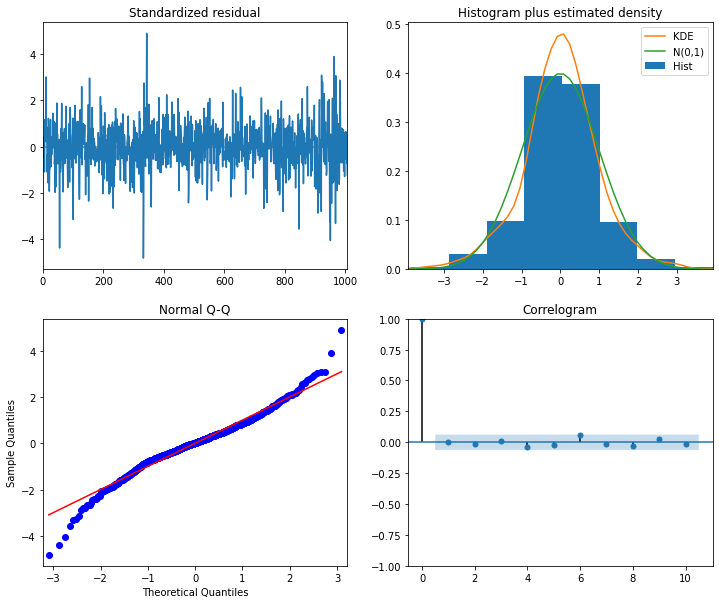

In [110]:
fig = plt.figure();
fig = model.plot_diagnostics();
fig.set_size_inches(12, 10);

## $\text{Predicting the entire test period}$

In [111]:
model.fit(train_return_data)
forecast = model.predict(n_periods=len(test_return_data))

In [112]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

MSE_error = mean_squared_error(test_return_data, forecast, squared=True)
print('Testing Mean Squared Error is {}'.format(round(MSE_error, 5)))

RMSE_error = mean_squared_error(test_return_data, forecast, squared=False)
print('Testing Root Mean Squared Error is {}'.format(round(RMSE_error, 5)))

MAE_error = mean_absolute_error(test_return_data, forecast)
print('Testing Mean Absolute Error is {}'.format(round(MAE_error, 5)))

#def MAPE(predict, target): return (abs((target - predict) / target).mean()) * 100
def MAPE(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Testing Mean Absolute Percentage Error is {}'.format(round(MAPE(forecast, test_return_data), 5)))

experiment1 = [round(MSE_error, 5), 
               round(RMSE_error, 5), 
               round(MAE_error, 5), 
               round(MAPE(forecast, test_return_data), 5)]

Testing Mean Squared Error is 0.00059
Testing Root Mean Squared Error is 0.02437
Testing Mean Absolute Error is 0.01811
Testing Mean Absolute Percentage Error is 1.82998


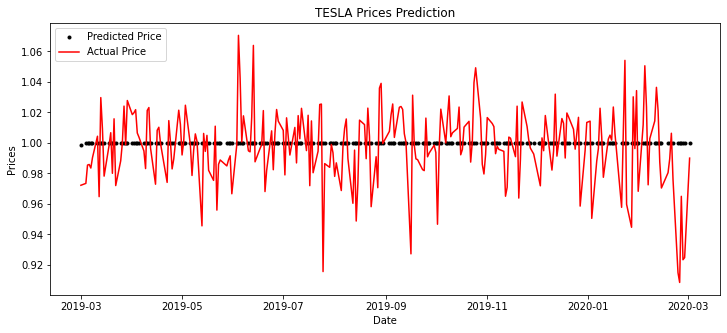

In [113]:
plt.figure(figsize=(12, 5))
plt.plot(test_return_data.index, forecast, 'k.', label='Predicted Price')
plt.plot(test_return_data.index, test_return_data, color='red', label='Actual Price')

plt.title('TESLA Prices Prediction')
plt.xlabel('Date'); plt.ylabel('Prices')
plt.legend(); plt.show()

## $\text{Predicting one day at a time}$

In [ ]:
history = list(train_return_data.values)

model_predictions = []

N_test_observations = len(test_return_data)

for time_point in list(test_return_data.index):
    model = ARIMA(history, order=(0, 0, 1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    model_predictions.append(yhat)
    true_test_value = test_return_data[time_point]
    history.append(true_test_value)

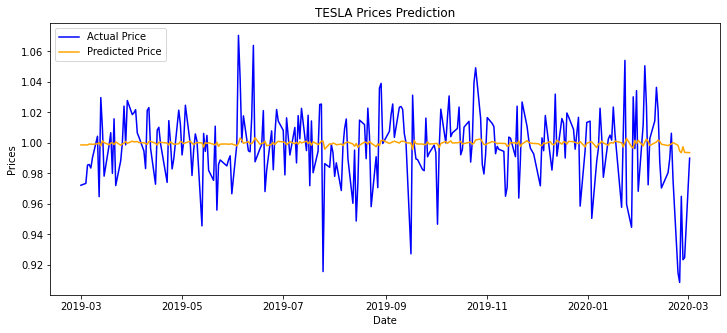

In [119]:
model_predictions = pd.Series(model_predictions, index = test_return_data.index)

plt.figure(figsize=(12,5))
#plt.plot(train_return_data, label='training')
plt.plot(test_return_data, color = 'blue', label='Actual Price')
plt.plot(model_predictions, color = 'orange',label='Predicted Price')

plt.title('TESLA Prices Prediction')
plt.xlabel('Date'); plt.ylabel('Prices')
plt.legend(); plt.show()

In [120]:
MSE_error = mean_squared_error(test_return_data, forecast, squared=True)
print('Testing Mean Squared Error is {}'.format(round(MSE_error, 5)))

RMSE_error = mean_squared_error(test_return_data, forecast, squared=False)
print('Testing Root Mean Squared Error is {}'.format(round(RMSE_error, 5)))

MAE_error = mean_absolute_error(test_return_data, forecast)
print('Testing Mean Absolute Error is {}'.format(round(MAE_error, 5)))

def MAPE(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Testing Mean Absolute Percentage Error is {}'.format(round(MAPE(forecast, test_return_data), 5)))

experiment2 = [round(MSE_error, 5), 
               round(RMSE_error, 5), 
               round(MAE_error, 5), 
               round(MAPE(forecast, test_return_data), 5)]

Testing Mean Squared Error is 0.00059
Testing Root Mean Squared Error is 0.02437
Testing Mean Absolute Error is 0.01811
Testing Mean Absolute Percentage Error is 1.82998


In [121]:
pd.DataFrame([experiment1, experiment2], 
             index=['All test period', 'One prediction at a time'], 
             columns=['MSE', 'RMSE', 'MAE', 'MAPE'])

,MSE,RMSE,MAE,MAPE
All test period,0.00059,0.02437,0.01811,1.82998
One prediction at a time,0.00059,0.02437,0.01811,1.82998
